In [145]:
# Importações
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set_style("dark")

## Objetivo

Este notebook está sendo feito como parte do "Bootcamp Cognizant Cloud Data Engineer" realizado pelo portal da Digital Innovation One e no curso "Análise de dados com Python e Pandas".

Considerando que não foi estabelecido um objetivo específico, tratando do conhecimento das bibliotecas, decidi fazer a análise exploratória (aula 7) e visualização de dados (aula 6) para o dataset do Gapminder que foi utilizado na aula 3 e não foi explorado com esses objetivos.

## Carregamento do dataset

In [10]:
# Carregamento do arquivo CSV
colunas = ['Pais', 'continente', 'Ano', 'Expectativa de vida', 'Pop Total', 'PIB per cap']
df = pd.read_csv("Gapminder.csv",error_bad_lines=False, sep=";", names=colunas, header=0)

In [11]:
df.head(5)

,Pais,continente,Ano,Expectativa de vida,Pop Total,PIB per cap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3312 entries, 0 to 3311
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Pais                 3312 non-null   object 
 1   continente           3011 non-null   object 
 2   Ano                  3312 non-null   int64  
 3   Expectativa de vida  3312 non-null   float64
 4   Pop Total            3312 non-null   int64  
 5   PIB per cap          3312 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 155.4+ KB


In [13]:
# Certifica se o país sem continente foi informado em outra linha com o continente preenchido
filtro1 = df['continente'].isnull()
continente_nulo = set(df[filtro1]['Pais'].unique())

filtro2 = df['continente'].notnull()
continente_informado = set(df[filtro2]['Pais'].unique())

print('Sem correspondência' if len(continente_informado.intersection(continente_nulo)) == 0 else continente_informado.intersection(continente_nulo))

Sem correspondência


## Análise Exploratória do dataset

In [15]:
# Informações básicas do dataset

print('Número de linhas no dataset: {}'.format(df.shape[0]))
print('Número de países: {}'.format(df['Pais'].unique().shape[0]))
print('Número de linhas nulas na coluna Continente: {}'.format(df['continente'].isnull().sum()))

Número de linhas no dataset: 3312
Número de países: 187
Número de linhas nulas na coluna Continente: 301


<AxesSubplot:ylabel='Pais'>

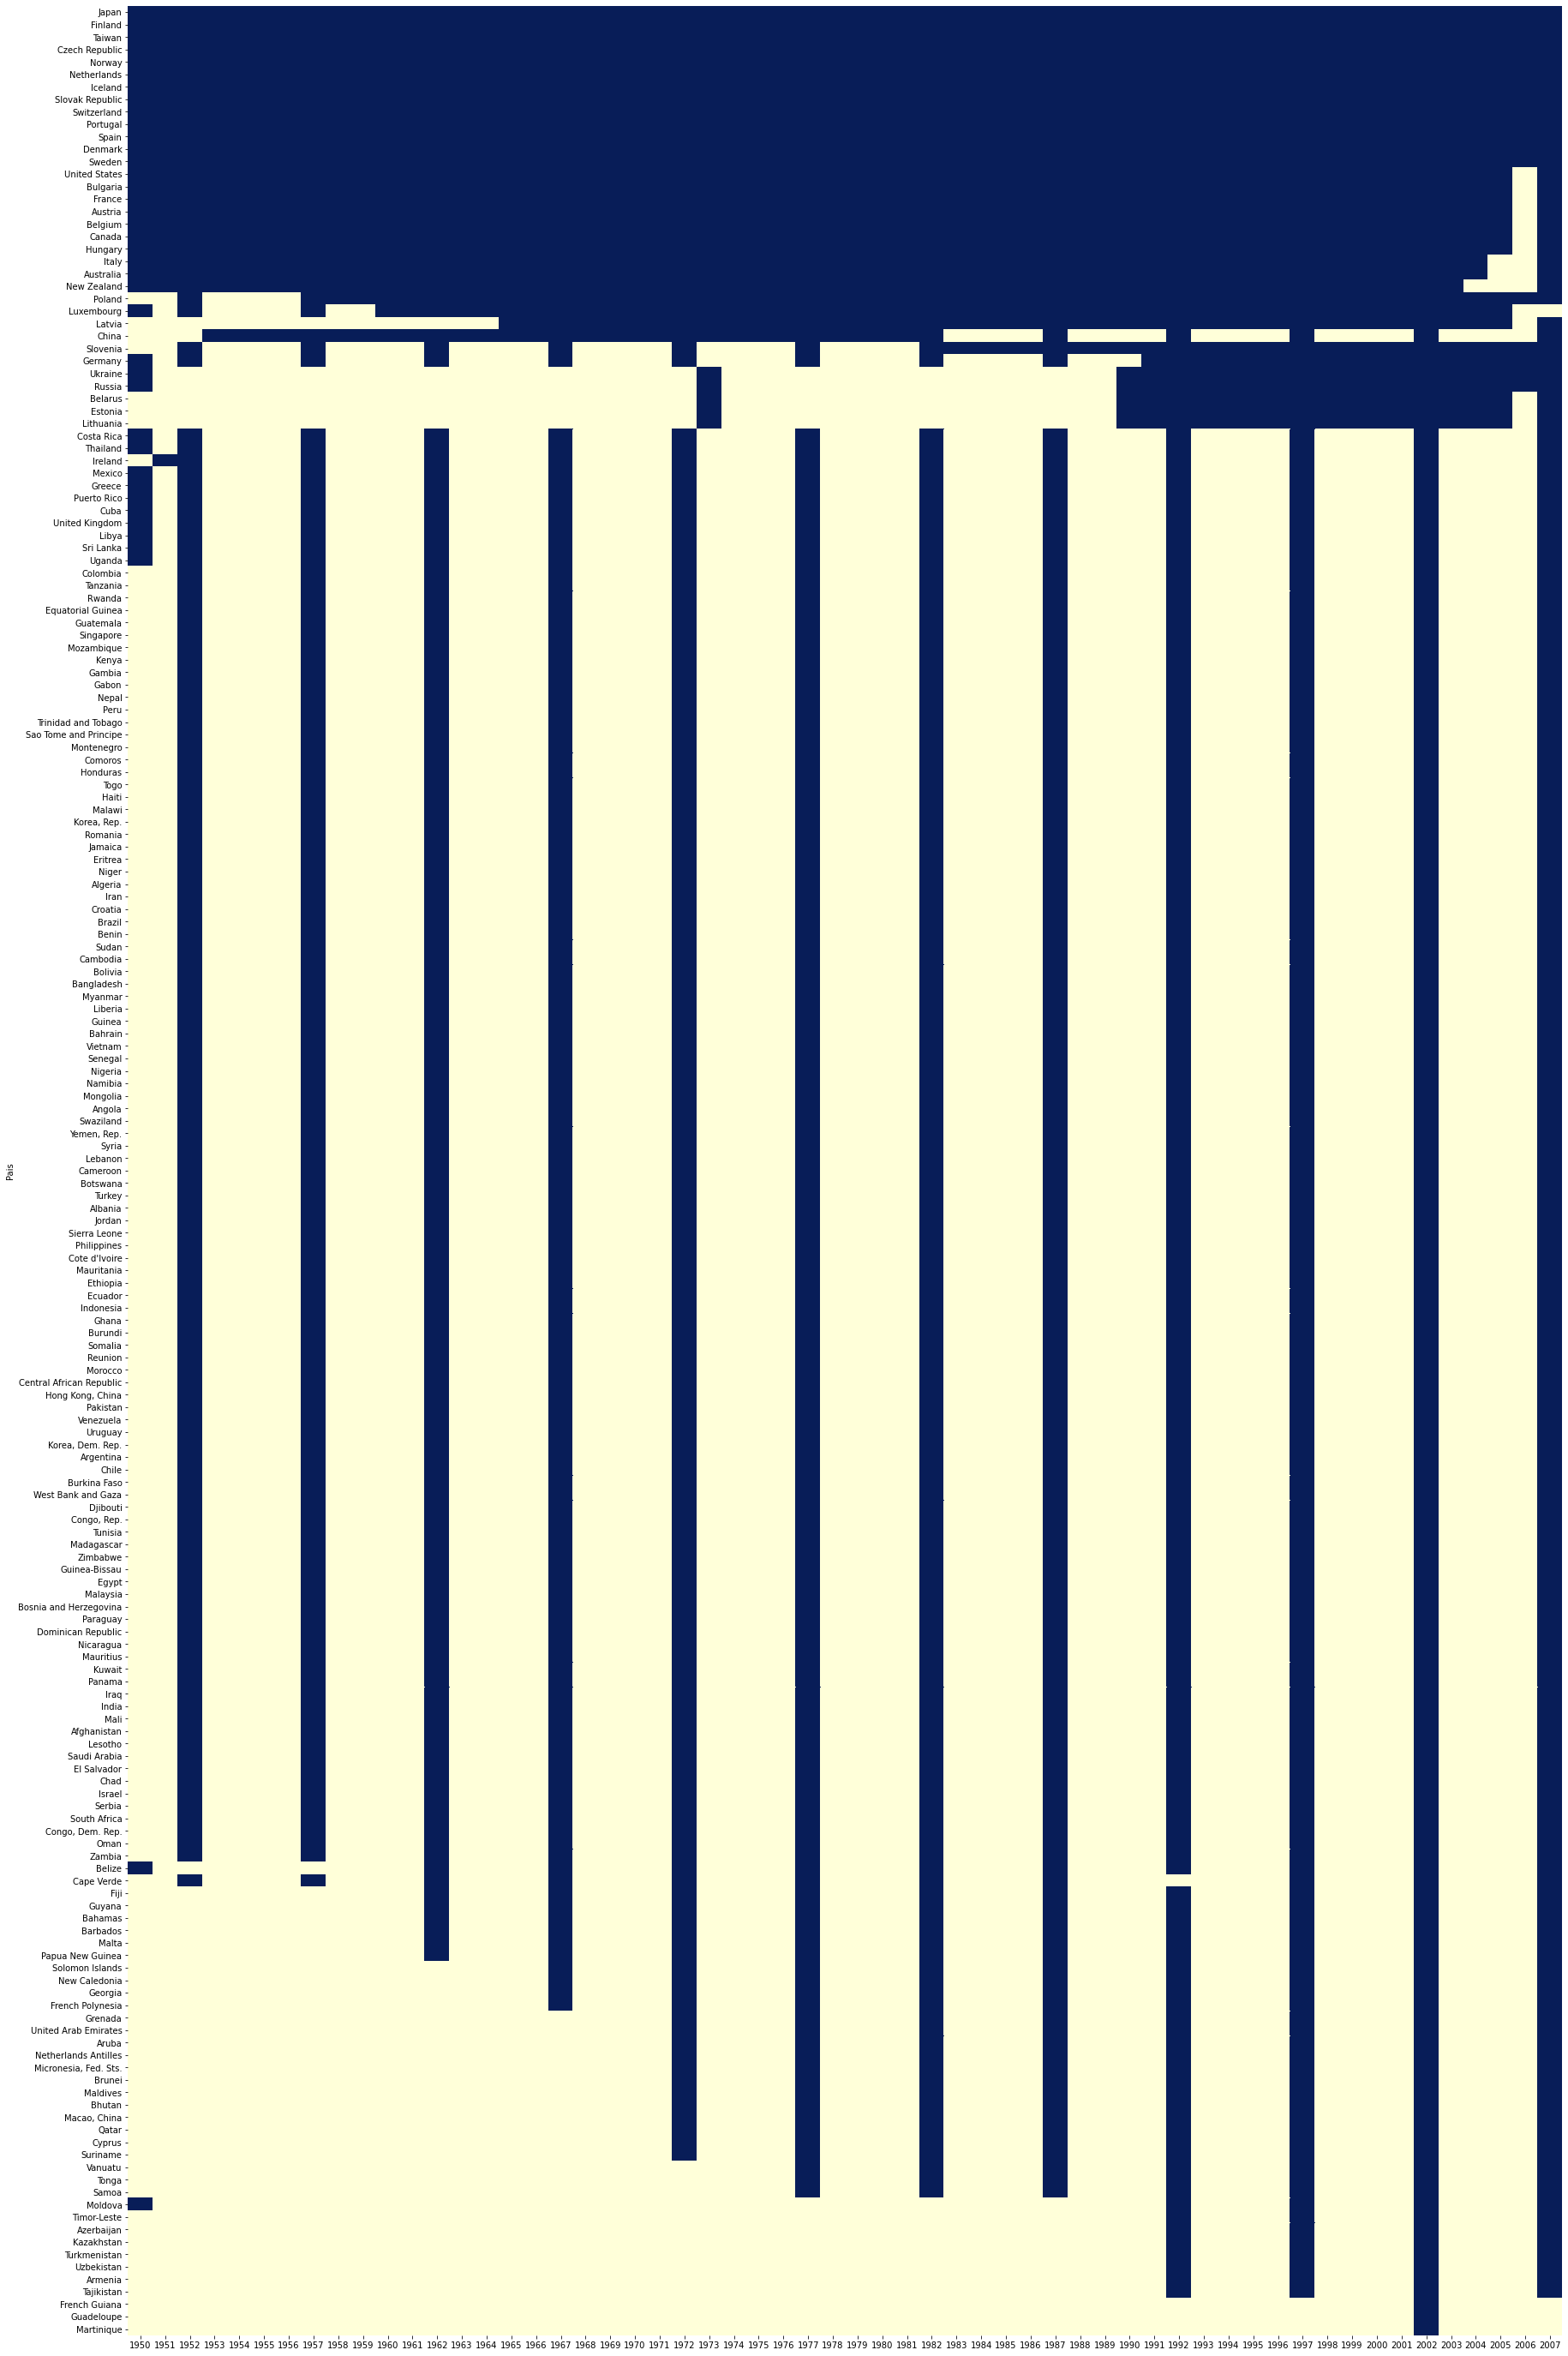

In [30]:
# Identificando visualmente quais anos os países têm disponível
df_numanos = df['Pais'].value_counts().reset_index().rename(columns={'index': 'Pais', 'Pais': 'Qt'})

df_heatmap = df.filter(['Pais', 'Ano'])
df_heatmap['flag'] = 1
df_heatmap = df_heatmap.pivot(index='Pais', columns='Ano', values='flag').fillna(0).reset_index()

df_heatmap = df_numanos.merge(df_heatmap, on='Pais').set_index('Pais')
df_heatmap.drop('Qt', axis=1, inplace=True)

fig, ax = pyplot.subplots(figsize=(30, 50))
sns.heatmap(df_heatmap, ax=ax, cbar=False, cmap="YlGnBu")

In [31]:
# Países com o número total de anos - 58
filtro1 = df['Pais'].value_counts().isin([58])
index = df['Pais'].value_counts().index

index[filtro1]

Index(['Japan', 'Finland', 'Taiwan', 'Czech Republic', 'Norway', 'Netherlands',
       'Iceland', 'Slovak Republic', 'Switzerland', 'Portugal', 'Spain',
       'Denmark', 'Sweden'],
      dtype='object')

Foi possível verificar que o Brasil não está entre os países que têm todos os anos .
Vamos partir para selecionar países com os mesmos dados que o Brasil.

In [38]:
# Anos que o Brazil tem disponível
anos_brazil = df[df['Pais'].str.contains('Brazil')]['Ano'].tolist()
maior_ano = max(anos_brazil)

print(anos_brazil)
print(maior_ano)

[1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002, 2007]
2007


In [35]:
# Criando uma lista de países que têm todos os mesmos períodos que o Brazil
paises_anos_brazil = set()

for i in range(0, len(anos_brazil)):
    filtro_ = df['Ano'] == anos_brazil[i]
    paises_ = set(df['Pais'][filtro_])
    
    if i == 0:
        paises_anos_brazil = paises_
    else:
        paises_anos_brazil = paises_anos_brazil.intersection(paises_)

In [36]:
print('São {} países que têm todos os mesmos anos que o Brasil.'.format(len(paises_anos_brazil)))

São 141 países que têm todos os mesmos anos que o Brasil.


In [149]:
# Separar apenas os países que têm os períodos iguais ao Brazil para comparação dos dados do último ano
filtro1 = df['Ano'] == maior_ano
filtro2 = df['Pais'].isin(paises_anos_brazil)

df_to_compare_brazil = df[filtro1 & filtro2].copy()

<AxesSubplot:xlabel='Pais', ylabel='Pop Total'>

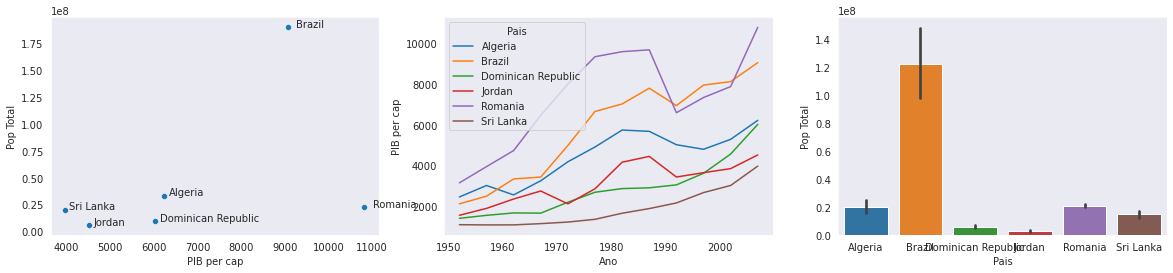

In [179]:
# Verificar os 5 países com expectativa de vida mais próximos do Brasil
brazil_expecvida = float(df_to_compare_brazil['Expectativa de vida'][df_to_compare_brazil['Pais'] == 'Brazil'])
df_to_compare_brazil['Dif_Expectativa'] = df_to_compare_brazil['Expectativa de vida'].map(lambda x: abs(x-brazil_expecvida))

df_expecvida = df_to_compare_brazil.sort_values(by='Dif_Expectativa').head(6).reset_index(drop=True)

filtro1 = df['Pais'].isin(df_expecvida['Pais'])
filtro2 = df['Ano'].isin(anos_brazil)

df_to_compare_brazil_anos = df[filtro1 & filtro2].copy()

fig, ax = pyplot.subplots(figsize=(20, 4), nrows=1, ncols=3)

# Comparação População e PIB
sns.scatterplot(data=df_expecvida, x='PIB per cap', y='Pop Total', ax=ax[0])
for i, pais in enumerate(df_expecvida['Pais']):
    x=int(df_expecvida['PIB per cap'][i])*1.02
    y=df_expecvida['Pop Total'][i]
    ax[0].text(x=x, y=y, s=pais)
    
# Crescimento PIB
sns.lineplot(data=df_to_compare_brazil_anos, 
             y='PIB per cap', x='Ano', ax=ax[1],
             hue='Pais', markers=True)

# Comparação População
sns.barplot(data=df_to_compare_brazil_anos, 
             y='Pop Total', x='Pais', ax=ax[2])

<AxesSubplot:xlabel='Pais', ylabel='Expectativa de vida'>

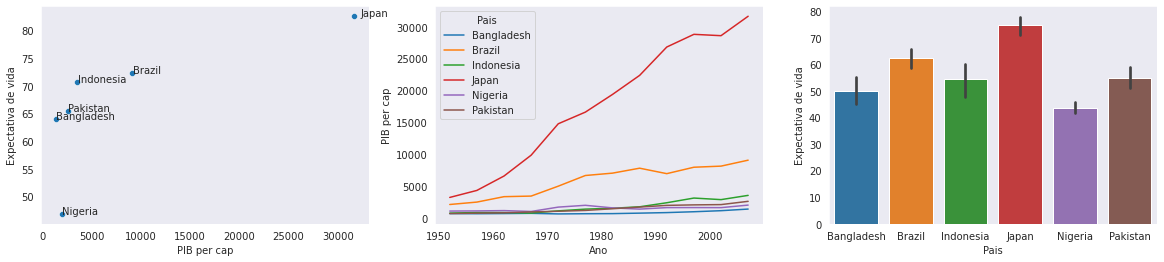

In [180]:
# Verificar os 5 países com População mais próximos do Brasil
brazil_pop = float(df_to_compare_brazil['Pop Total'][df_to_compare_brazil['Pais'] == 'Brazil'])
df_to_compare_brazil['Dif_Pop'] = df_to_compare_brazil['Pop Total'].map(lambda x: abs(x-brazil_pop))

df_poptotal = df_to_compare_brazil.sort_values(by='Dif_Pop').head(6).reset_index(drop=True)

filtro1 = df['Pais'].isin(df_poptotal['Pais'])
filtro2 = df['Ano'].isin(anos_brazil)

df_to_compare_brazil_anos = df[filtro1 & filtro2].copy()

fig, ax = pyplot.subplots(figsize=(20, 4), nrows=1, ncols=3)

# Comparação Expec Vida e PIB
sns.scatterplot(data=df_poptotal, x='PIB per cap', y='Expectativa de vida', ax=ax[0])
for i, pais in enumerate(df_poptotal['Pais']):
    x=int(df_poptotal['PIB per cap'][i])*1.02
    y=df_poptotal['Expectativa de vida'][i]
    ax[0].text(x=x, y=y, s=pais)
    
# Crescimento PIB
sns.lineplot(data=df_to_compare_brazil_anos, 
             y='PIB per cap', x='Ano', ax=ax[1],
             hue='Pais', markers=True)

# Comparação População
sns.barplot(data=df_to_compare_brazil_anos, 
             y='Expectativa de vida', x='Pais', ax=ax[2], units='Ano')

<AxesSubplot:xlabel='Pais', ylabel='Expectativa de vida'>

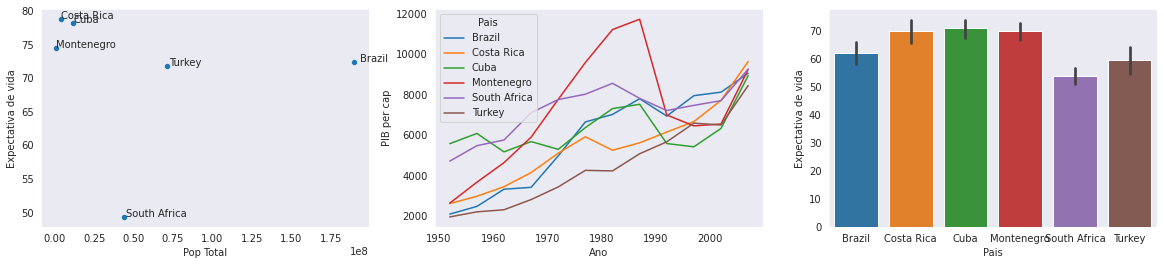

In [183]:
# Verificar os 5 países com PIB per capta mais próximos do Brasil
brazil_pib = float(df_to_compare_brazil['PIB per cap'][df_to_compare_brazil['Pais'] == 'Brazil'])
df_to_compare_brazil['Dif_PIB'] = df_to_compare_brazil['PIB per cap'].map(lambda x: abs(x-brazil_pib))

df_pib = df_to_compare_brazil.sort_values(by='Dif_PIB').head(6).reset_index(drop=True)

filtro1 = df['Pais'].isin(df_pib['Pais'])
filtro2 = df['Ano'].isin(anos_brazil)

df_to_compare_brazil_anos = df[filtro1 & filtro2].copy()

fig, ax = pyplot.subplots(figsize=(20, 4), nrows=1, ncols=3)

# Comparação Expec Vida e PIB
sns.scatterplot(data=df_pib, x='Pop Total', y='Expectativa de vida', ax=ax[0])
for i, pais in enumerate(df_pib['Pais']):
    x=int(df_pib['Pop Total'][i])*1.02
    y=df_pib['Expectativa de vida'][i]
    ax[0].text(x=x, y=y, s=pais)
    
# Crescimento PIB
sns.lineplot(data=df_to_compare_brazil_anos, 
             y='PIB per cap', x='Ano', ax=ax[1],
             hue='Pais', markers=True)

# Comparação População
sns.barplot(data=df_to_compare_brazil_anos, 
             y='Expectativa de vida', x='Pais', ax=ax[2], units='Ano')